# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц можно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [2]:
XdotX = 0
XdotT = 0
relevant_idx = 0

def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    
    relevant_idx[:] = alpha < 1e8

    S = np.linalg.inv(
        beta * XdotX[relevant_idx][:, relevant_idx] +
        np.diag(alpha[relevant_idx])
    )
    
    w = np.zeros(d)
    w[relevant_idx] = beta * S.dot(XdotT[relevant_idx])
    
    return w, S

def update_alpha_beta(X, t, alpha, beta):
    """Update the hyperperemeters to increase evidence"""
    n, d = X.shape

    w, S = get_w_sigma(X, t, alpha, beta)

    gamma = 1 - alpha[relevant_idx] * np.diag(S)
    alpha[relevant_idx] = gamma / (w[relevant_idx] ** 2)
    alpha[~relevant_idx] = np.inf

    tmp = t - X.dot(w)
    beta = (n - gamma.sum()) / tmp.dot(tmp)

    return alpha, beta


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""

    alpha = np.ones(X.shape[1])
    beta = 1
    
    global XdotX, XdotT, relevant_idx
    XdotX = X.T.dot(X)
    XdotT = X.T.dot(t)
    relevant_idx = np.ones(X.shape[1], dtype=np.bool)
    
    for i in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta)
    
    w, sigma = get_w_sigma(X, t, alpha, beta)
    S = np.zeros_like(XdotX)
    S[relevant_idx][:, relevant_idx] = sigma
    return w, S, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

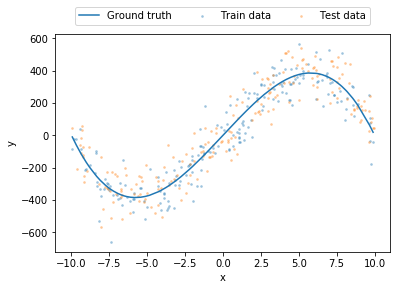

In [3]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-10, 10, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 100
w_true[3] = -1
beta_true = 1e-4

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [4]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [5]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [6]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=20, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

/home/ospanoff/.venvs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ospanoff/.venvs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Relevance Vector Regression
Features remaining: 3 / 21
Train error: 9052.79670931
Test error:  9793.46412659
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 8090.95319205
Test error:  12257.0104854
--------------------------------------------------
Lasso Regression
Features remaining: 19 / 21
Train error: 8941.22847976
Test error:  10237.8405027


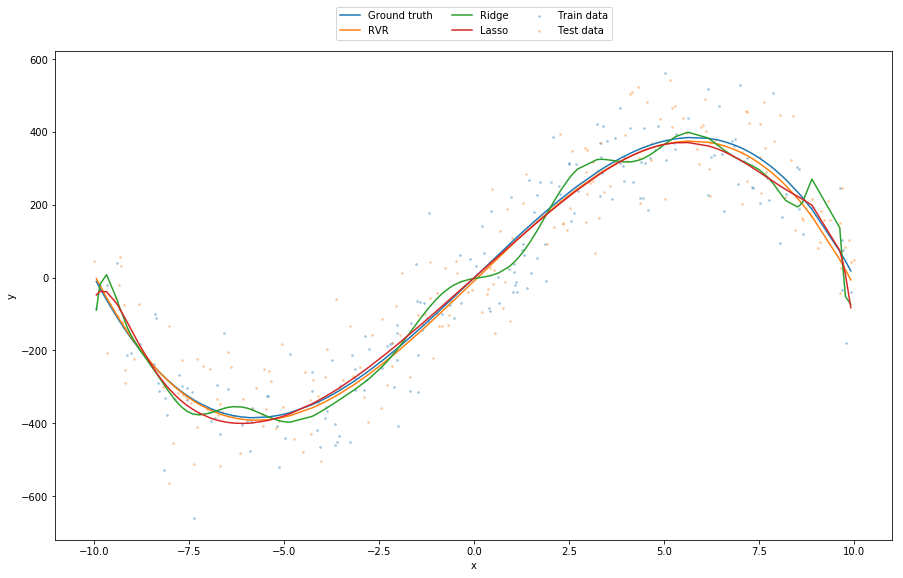

In [7]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

plt.figure(figsize=(15, 9))

plt.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
plt.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
plt.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
plt.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
plt.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.1))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

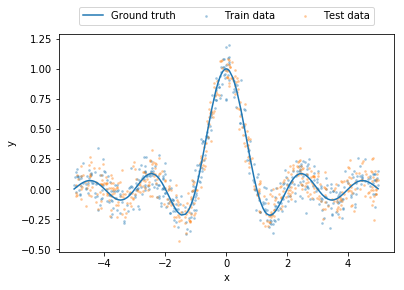

In [8]:
# Генерация данных
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 500
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train[:, np.newaxis])
X_test = rbf_kernel(points_test[:, np.newaxis])

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n, 1)), X_test))

# Visualization
plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [9]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train, max_iter=30000)

In [10]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.arange(-6, 3, 1),
                fit_intercept=False).fit(X_train, t_train)
w_lasso = lasso.coef_

/home/ospanoff/.venvs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ospanoff/.venvs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [11]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 11 / 500
Train error: 0.00944546665492
Test error:  0.033881419613
--------------------------------------------------
Lasso Regression
Objects remaining: 148 / 500
Train error: 0.00945624997543
Test error:  0.0278553560158
--------------------------------------------------
Support Vector Regression
Objects remaining: 163 / 500
Train error: 0.00947339517678
Test error:  0.00948180161155


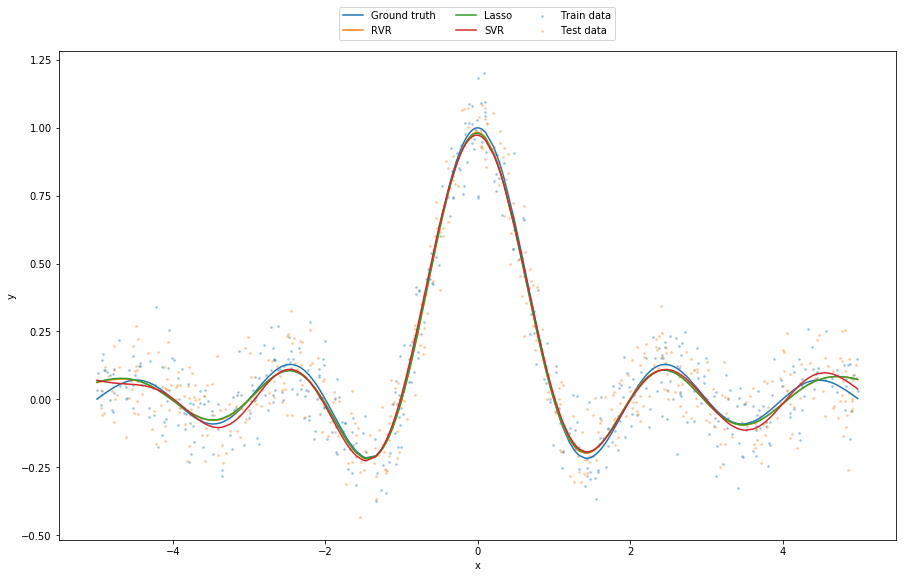

In [12]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

plt.figure(figsize=(15, 9))

plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')
plt.plot(points_train, X_train.dot(w_lasso), label='Lasso')
plt.plot(points_train, svr.predict(points_train.reshape(-1, 1)), label='SVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.1))
plt.show()

### Визуализация релевантных объектов для RVR

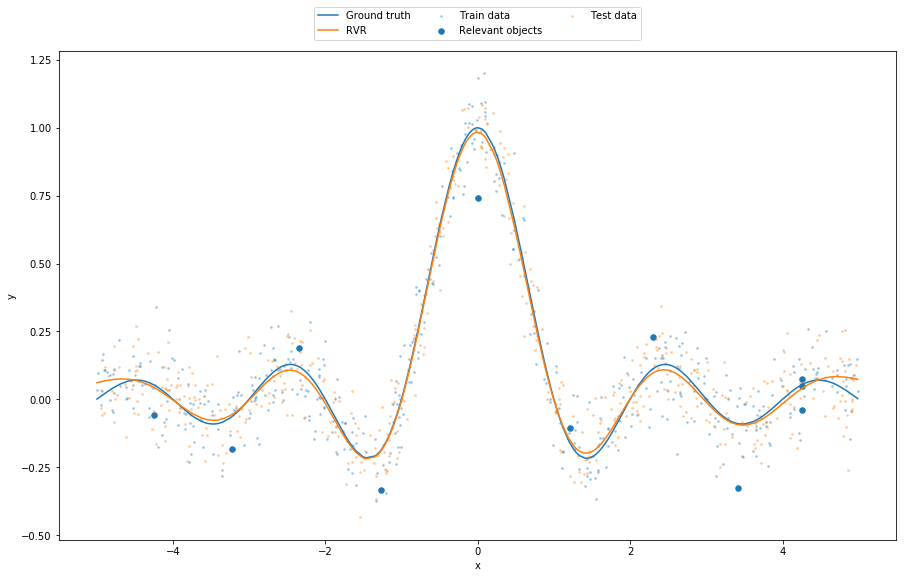

In [13]:
relevant = alpha_rvr[1:] < 1e8

plt.figure(figsize=(15, 9))

plt.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
plt.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
plt.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
plt.plot(points_train, np.sinc(points_train), label='Ground truth')
plt.plot(points_train, X_train.dot(w_rvr), label='RVR')

plt.axes().set_xlabel('x')
plt.axes().set_ylabel('y')
plt.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.1))
plt.show()

## Выводы
В первом синтетическом тесте лучшие результаты показал RVR: по графику видно, что он хорошо аппроксимирует исходный многочлен, а ошибка на тестовых данных, которая меньше двух других методов это подтверждает. Методы Lasso и Ridge тоже показывают хорошую аппроксимацию, но т.к. Lasso выбрал 19 степень для многочлена 3й степени, метод переобучился. Аналогичная ситуация с Ridge, т.к. он использует все фичи. Во втором тесте методы показывают примерно одинаковые результаты.

В итоге можно заключить, что RVR имеет преимущество, т.к. выдает разреженный результат и дисперсию прогноза.